# 第8部　正規線形モデル

## 4章　複数の説明変数を持つモデル

### 実装：分析の準備

In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd
from scipy import stats
# 表示桁数の設定
pd.set_option('display.precision', 3)
np.set_printoptions(precision=3)

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# 統計モデルを推定するライブラリ
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
# 表示設定(書籍本文のレイアウトと合わせるためであり、必須ではありません)
np.set_printoptions(linewidth=65)
pd.set_option('display.width', 65)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

In [3]:
# データの読み込み
brand_1 = pd.read_csv('8-4-1-brand-1.csv')
print(brand_1.head(n=3))

   sales brand  local_population
0  348.0     A             215.1
1  169.7     A             152.0
2  143.7     A             107.7


In [4]:
# ブランド
brand_1.brand.value_counts()

A    15
B    15
Name: brand, dtype: int64

### 実装：（悪い分析例）単純な平均値の比較

#### 平均値の比較

In [5]:
# ブランド別平均値の比較
print(brand_1.groupby('brand').mean())

         sales  local_population
brand                           
A      283.707           268.973
B      403.927           437.933


<AxesSubplot:xlabel='brand', ylabel='sales'>

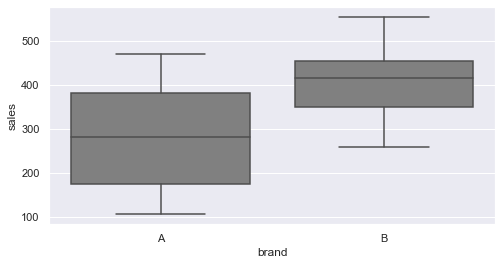

In [6]:
# ブランドと売り上げの関係
sns.boxplot(x='brand', y='sales', data=brand_1, color='gray')

#### 説明変数を1つだけ使ったモデル

In [7]:
lm_dame_1 = smf.ols('sales ~ brand', brand_1).fit()
lm_dame_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,283.7067,26.602,10.665,0.000,229.214,338.199
brand[T.B],120.2200,37.622,3.196,0.003,43.156,197.284


In [8]:
# 分散分析表
print(sm.stats.anova_lm(lm_dame_1, typ=1).round(3))

            df      sum_sq     mean_sq       F  PR(>F)
brand      1.0  108396.363  108396.363  10.211   0.003
Residual  28.0  297230.019   10615.358     NaN     NaN


### 実装：回帰直線の切片の比較

In [9]:
lm_model_1 = smf.ols('sales ~ brand + local_population', 
                     data=brand_1).fit()
lm_model_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,101.0946,31.535,3.206,0.003,36.389,165.800
brand[T.B],5.5093,28.768,0.192,0.850,-53.518,64.537
local_population,0.6789,0.100,6.790,0.000,0.474,0.884


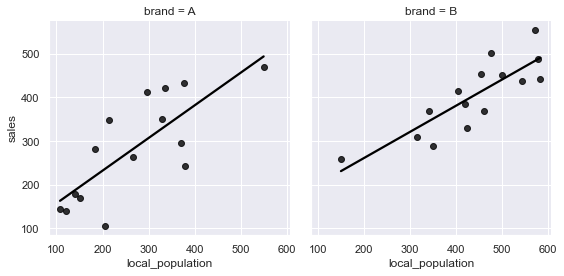

In [10]:
sns.lmplot(x='local_population', y='sales', data=brand_1,
           col='brand',           
           scatter_kws = {'color': 'black'},
           line_kws    = {'color': 'black'},
           ci=None, height=4, aspect=1)

### 実装：素朴な分散分析による検定

In [11]:
# 分散分析表
print(sm.stats.anova_lm(lm_model_1, typ=1).round(3))

                    df      sum_sq     mean_sq       F  PR(>F)
brand              1.0  108396.363  108396.363  26.658     0.0
local_population   1.0  187442.822  187442.822  46.098     0.0
Residual          27.0  109787.197    4066.192     NaN     NaN


### 実装：複数の説明変数がある場合の平方和の計算

#### 「Nullモデル」の作成

In [12]:
# Nullモデルの残差平方和
mod_null = smf.ols('sales ~ 1', brand_1).fit()
resid_sq_null = np.sum(mod_null.resid ** 2)
round(resid_sq_null, 3)

405626.382

#### 「Nullモデル」と「ブランドモデル」の比較

In [13]:
# ブランドだけを入れたモデルの残差平方和
resid_sq_brand = np.sum(lm_dame_1.resid ** 2)
round(resid_sq_brand, 3)

297230.019

In [14]:
round(resid_sq_null - resid_sq_brand, 3)

108396.363

In [15]:
print(sm.stats.anova_lm(lm_dame_1, typ=1).round(3))

            df      sum_sq     mean_sq       F  PR(>F)
brand      1.0  108396.363  108396.363  10.211   0.003
Residual  28.0  297230.019   10615.358     NaN     NaN


#### 「ブランドモデル」と「ブランド＋地域人口モデル」の比較

In [16]:
# ブランド+地域人口モデルの残差平方和
resid_sq_all = np.sum(lm_model_1.resid ** 2)
round(resid_sq_all, 3)

109787.197

In [17]:
round(resid_sq_brand - resid_sq_all, 3)

187442.822

In [18]:
print(sm.stats.anova_lm(lm_model_1, typ=1).round(3))

                    df      sum_sq     mean_sq       F  PR(>F)
brand              1.0  108396.363  108396.363  26.658     0.0
local_population   1.0  187442.822  187442.822  46.098     0.0
Residual          27.0  109787.197    4066.192     NaN     NaN


### 実装：Type II 検定

#### 調整平方和の計算

In [19]:
# 地域人口だけを入れたモデルの残差平方和
lm_model_pop = smf.ols('sales ~ local_population', 
                     data=brand_1).fit()
resid_sq_pop = np.sum(lm_model_pop.resid ** 2)
round(resid_sq_pop, 3)

109936.322

In [20]:
round(resid_sq_pop - resid_sq_all, 3)

149.125

#### Type II 検定の実行

In [21]:
print(sm.stats.anova_lm(lm_model_1, typ=2).round(3))

                      sum_sq    df       F  PR(>F)
brand                149.125   1.0   0.037    0.85
local_population  187442.822   1.0  46.098    0.00
Residual          109787.197  27.0     NaN     NaN


In [22]:
# 2つのモデルの比較
np.round(lm_model_1.compare_f_test(lm_model_pop), 3)

array([0.037, 0.85 , 1.   ])

### 実装：新たなデータの読み込み

In [23]:
# データの読み込み
brand_2 = pd.read_csv('8-4-2-brand-2.csv')
print(brand_2.head(n=3))

   sales brand  local_population
0  385.8     A             265.6
1  473.0     A             386.1
2  451.6     A             522.7


### 実装：（悪い分析例）交互作用を入れないでモデルを作る

In [24]:
lm_dame_2 = smf.ols('sales ~ brand + local_population', 
                    brand_2).fit()
print(sm.stats.anova_lm(lm_dame_2, typ=2).round(3))

                      sum_sq    df        F  PR(>F)
brand                 34.275   1.0    0.007   0.933
local_population  484195.711   1.0  100.427   0.000
Residual          226604.693  47.0      NaN     NaN


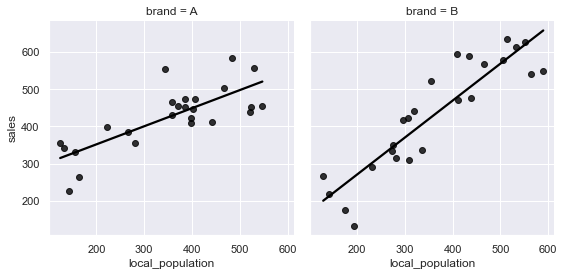

In [25]:
sns.lmplot(x='local_population', y='sales', data=brand_2,
           col='brand',           
           scatter_kws = {'color': 'black'},
           line_kws    = {'color': 'black'},
           ci=None, height=4, aspect=1)

### 実装：交互作用を入れたモデルの作成

In [26]:
# 交互作用を入れたモデルを作る
lm_model_2 = smf.ols('sales ~ brand * local_population', 
                     data=brand_2).fit()
lm_model_2.params

Intercept                      254.524
brand[T.B]                    -182.924
local_population                 0.486
brand[T.B]:local_population      0.508
dtype: float64

In [27]:
# 下記のように実装しても同じ
lm_model_2_2 = smf.ols('sales ~ brand + local_population + brand:local_population', 
                       data=brand_2).fit()
lm_model_2_2.params

Intercept                      254.524
brand[T.B]                    -182.924
local_population                 0.486
brand[T.B]:local_population      0.508
dtype: float64

### 実装：Type III 検定

#### Type II 検定の実行

In [28]:
# type II 検定
print(sm.stats.anova_lm(lm_model_2, typ=2).round(3))

                            sum_sq    df        F  PR(>F)
brand                       34.275   1.0    0.009   0.924
local_population        484195.711   1.0  130.689   0.000
brand:local_population   56176.608   1.0   15.163   0.000
Residual                170428.085  46.0      NaN     NaN


#### 調整平方和の計算

In [29]:
# フルモデルの残差平方和
resid_sq_full = np.sum(lm_model_2.resid ** 2)
round(resid_sq_full, 3)

170428.085

In [30]:
mod_non_brand = smf.ols(
    'sales ~ local_population + brand:local_population', 
    data=brand_2).fit()
resid_sq_non_brand = np.sum(mod_non_brand.resid ** 2)
round(resid_sq_non_brand, 3)

220745.808

In [31]:
# 調整平方和
round(resid_sq_non_brand - resid_sq_full, 3)

50317.723

#### Type III 検定の実行

In [32]:
# type III 検定
print(sm.stats.anova_lm(lm_model_2, typ=3).round(3))

                            sum_sq    df       F  PR(>F)
Intercept               195523.067   1.0  52.773   0.000
brand                    50317.723   1.0  13.581   0.001
local_population        100639.827   1.0  27.164   0.000
brand:local_population   56176.608   1.0  15.163   0.000
Residual                170428.085  46.0     NaN     NaN


### 実装：AICによる変数選択

In [33]:
print('交互作用なしモデルのAIC', round(lm_dame_2.aic, 3))
print('交互作用ありモデルのAIC', round(lm_model_2.aic, 3))

交互作用なしモデルのAIC 568.841
交互作用ありモデルのAIC 556.596


### 実装：交互作用項の解釈

#### 係数の取得

In [34]:
lm_model_2.params

Intercept                      254.524
brand[T.B]                    -182.924
local_population                 0.486
brand[T.B]:local_population      0.508
dtype: float64

In [35]:
# 係数を個別に取得
Intercept = lm_model_2.params[0]
coef_brand_B = lm_model_2.params[1]
coef_local_population = lm_model_2.params[2]
Interaction = lm_model_2.params[3]

#### local_population=0のときの予測値

In [36]:
# brand=Aで、かつ、local_population=0
lm_model_2.predict(
    pd.DataFrame({'brand':['A'], 'local_population':[0]}))

0    254.524
dtype: float64

In [37]:
pred_1 = Intercept
round(pred_1, 3)

254.524

In [38]:
# brand=Bで、かつ、local_population=0
lm_model_2.predict(
    pd.DataFrame({'brand':['B'], 'local_population':[0]}))

0    71.599
dtype: float64

In [39]:
pred_2 = Intercept + coef_brand_B
round(pred_2, 3)

71.599

#### local_population=150のときの予測値

In [40]:
# brand=Aで、かつ、local_population=150
lm_model_2.predict(
    pd.DataFrame({'brand':['A'], 'local_population':[150]}))

0    327.413
dtype: float64

In [41]:
pred_3 = Intercept + coef_local_population * 150
round(pred_3, 3)

327.413

In [42]:
# brand=Bで、かつ、local_population=150
lm_model_2.predict(
    pd.DataFrame({'brand':['B'], 'local_population':[150]}))

0    220.679
dtype: float64

In [43]:
pred_4 = Intercept + coef_brand_B + \
   (coef_local_population + Interaction) * 150
round(pred_4, 3)

220.679

### 実装：formula構文の機能

In [44]:
# データの読み込み
brand_3 = pd.read_csv('8-4-3-brand-3.csv')
print(brand_3.head(n=3))

   sales  brand  local_population
0  385.8    0.0             265.6
1  473.0    0.0             386.1
2  451.6    0.0             522.7


In [45]:
# 参考：もとのデータ(書籍には載っていないコードです)
brand_2.brand.value_counts()

A    25
B    25
Name: brand, dtype: int64

In [46]:
# ブランドを数値で表現したデータ
brand_3.brand.value_counts()

0.0     25
99.0    25
Name: brand, dtype: int64

In [47]:
# ブランドが数値扱いになっているので係数が変わる
lm_model_3 = smf.ols(
    'sales ~ brand * local_population', 
    data=brand_3).fit()
lm_model_3.params

Intercept                 254.524
brand                      -1.848
local_population            0.486
brand:local_population      0.005
dtype: float64

In [48]:
# ブランドをカテゴリーとして扱う
lm_model_3_2 = smf.ols(
    'sales ~ C(brand) * local_population', 
    data=brand_3).fit()
lm_model_3_2.params

Intercept                            254.524
C(brand)[T.99.0]                    -182.924
local_population                       0.486
C(brand)[T.99.0]:local_population      0.508
dtype: float64

In [49]:
# 参考：パラメータの一覧(書籍には載っていないコードです)
lm_model_2.params

Intercept                      254.524
brand[T.B]                    -182.924
local_population                 0.486
brand[T.B]:local_population      0.508
dtype: float64

### 実装：デザイン行列

In [50]:
from patsy import dmatrix
dmatrix('brand * local_population', brand_2)

DesignMatrix with shape (50, 4)
  Intercept  brand[T.B]  local_population  brand[T.B]:local_population
          1           0             265.6                          0.0
          1           0             386.1                          0.0
          1           0             522.7                          0.0
          1           0             530.5                          0.0
          1           0             397.8                          0.0
          1           0             142.3                          0.0
          1           0             398.6                          0.0
          1           0             222.7                          0.0
          1           0             466.3                          0.0
          1           0             547.3                          0.0
          1           0             357.4                          0.0
          1           0             401.8                          0.0
          1           0             132.5    